# Synthetic mitochondria, full pipeline and phenotype hierarchy, reproducible notebook


This notebook combines the complete synthetic mitochondria workflow with a phenotype hierarchy extension.
It generates synthetic datasets, simulates a simple proton motive force model, visualizes time series and endpoints,
fits kinetic parameters from a mock calorimetry style dataset, ranks synthetic designs by a simple efficiency score,
then defines phenotype like parameter sets and ranks them by a composite score.
All plots use matplotlib only.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

OUT = Path("results_full")
OUT.mkdir(exist_ok=True, parents=True)
print("output directory:", OUT.resolve())


output directory: /Users/petalc01/Computational modelling of synthetic mitochondria/results_full


## Simulator for proton motive force, ATP, and heat outputs

In [5]:

def simulate_system(
    t_end=300.0,
    dt=0.5,
    pump_rate=1.0,
    k_atp=0.020,
    k_u=0.015,
    ucp1_activation=0.4,
    cond_loss=0.002,
    adp_level=0.8,
    pmf_init=0.0,
    toggle="MIXED"  # choices are ATP, HEAT, MIXED
):
    n = int(t_end / dt) + 1
    t = np.linspace(0, t_end, n)
    pmf = np.zeros(n)
    pmf[0] = pmf_init
    atp_rate = np.zeros(n)
    heat_rate = np.zeros(n)

    for i in range(1, n):
        f_adp = adp_level / (0.3 + adp_level)
        atp_flux = k_atp * pmf[i-1] * f_adp
        ucp_flux = k_u * pmf[i-1] * ucp1_activation
        if toggle == "ATP":
            ucp_flux *= 0.2
        elif toggle == "HEAT":
            atp_flux *= 0.2
        dpmf = pump_rate - atp_flux - ucp_flux - cond_loss * pmf[i-1]
        pmf[i] = max(0.0, pmf[i-1] + dt * dpmf)
        atp_rate[i] = atp_flux
        heat_rate[i] = ucp_flux

    atp_cum = np.cumsum(atp_rate) * dt
    heat_cum = np.cumsum(heat_rate) * dt

    import pandas as pd
    return pd.DataFrame({
        "time_s": t,
        "pmf": pmf,
        "atp_rate": atp_rate,
        "heat_rate": heat_rate,
        "atp_cum": atp_cum,
        "heat_cum": heat_cum
    })
print("simulator ready")


simulator ready


## Generate a grid of synthetic runs and save a dataset

In [8]:

pump_rates = [0.6, 1.0, 1.4]
ucp_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
adp_levels = [0.3, 0.6, 1.0]
modes = ["ATP", "HEAT", "MIXED"]

frames = []
for pr in pump_rates:
    for ul in ucp_levels:
        for al in adp_levels:
            for md_mode in modes:
                df = simulate_system(
                    pump_rate=pr,
                    ucp1_activation=ul,
                    adp_level=al,
                    toggle=md_mode
                )
                df["pump_rate"] = pr
                df["ucp1_activation"] = ul
                df["adp_level"] = al
                df["mode"] = md_mode
                frames.append(df)
sim = pd.concat(frames, ignore_index=True)
sim_path = OUT / "synthetic_mito_dataset.csv"
sim.to_csv(sim_path, index=False)
print("wrote", sim_path)
sim.head()


wrote results_full/synthetic_mito_dataset.csv


,time_s,pmf,atp_rate,heat_rate,atp_cum,heat_cum,pump_rate,ucp1_activation,adp_level,mode
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.6,0.0,0.3,ATP
1,0.5,0.300000,0.000000,0.0,0.000000,0.0,0.6,0.0,0.3,ATP
2,1.0,0.598200,0.003000,0.0,0.001500,0.0,0.6,0.0,0.3,ATP
3,1.5,0.894611,0.005982,0.0,0.004491,0.0,0.6,0.0,0.3,ATP
4,2.0,1.189243,0.008946,0.0,0.008964,0.0,0.6,0.0,0.3,ATP


## Visualize a single representative run

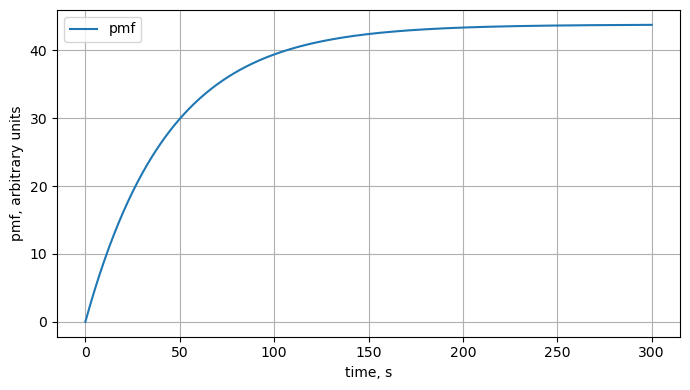

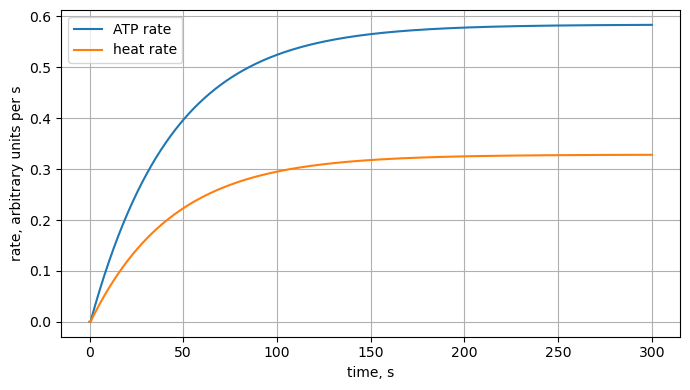

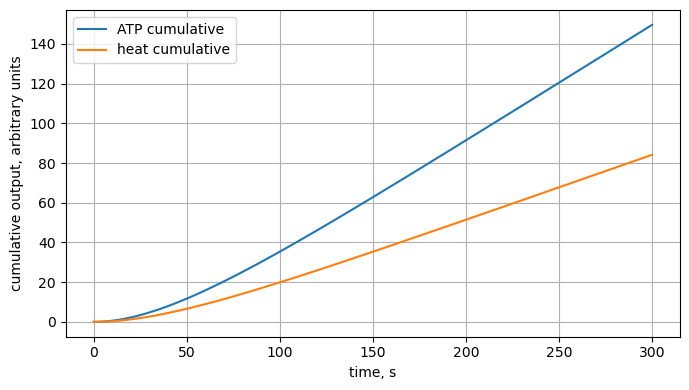

In [11]:

ex = sim[(sim["pump_rate"]==1.0)&(sim["ucp1_activation"]==0.5)&(sim["adp_level"]==0.6)&(sim["mode"]=="MIXED")]
fig, ax = plt.subplots()
ax.plot(ex["time_s"], ex["pmf"], label="pmf")
ax.set_xlabel("time, s"); ax.set_ylabel("pmf, arbitrary units"); ax.legend()
plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
ax.plot(ex["time_s"], ex["atp_rate"], label="ATP rate")
ax.plot(ex["time_s"], ex["heat_rate"], label="heat rate")
ax.set_xlabel("time, s"); ax.set_ylabel("rate, arbitrary units per s"); ax.legend()
plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
ax.plot(ex["time_s"], ex["atp_cum"], label="ATP cumulative")
ax.plot(ex["time_s"], ex["heat_cum"], label="heat cumulative")
ax.set_xlabel("time, s"); ax.set_ylabel("cumulative output, arbitrary units"); ax.legend()
plt.tight_layout(); plt.show()


## Compute endpoints and a simple efficiency score

In [14]:

endpoints = sim.groupby(["pump_rate","ucp1_activation","adp_level","mode"]).tail(1).copy()
endpoints["efficiency"] = endpoints["atp_cum"] / (endpoints["atp_cum"] + endpoints["heat_cum"] + 1e-9)
endpoints_path = OUT / "synthetic_mito_endpoints.csv"
endpoints.to_csv(endpoints_path, index=False)
print("wrote", endpoints_path)
endpoints[["pump_rate","ucp1_activation","adp_level","mode","pmf","atp_cum","heat_cum","efficiency"]].head()


wrote results_full/synthetic_mito_endpoints.csv


,pump_rate,ucp1_activation,adp_level,mode,pmf,atp_cum,heat_cum,efficiency
600,0.6,0.0,0.3,ATP,48.648548,109.459543,0.0,1.0
1201,0.6,0.0,0.3,HEAT,104.875123,37.562439,0.0,1.0
1802,0.6,0.0,0.3,MIXED,48.648548,109.459543,0.0,1.0
2403,0.6,0.0,0.6,ATP,38.744012,122.831294,0.0,1.0
3004,0.6,0.0,0.6,HEAT,96.917928,47.475470,0.0,1.0


## Trade off between ATP and heat at run end

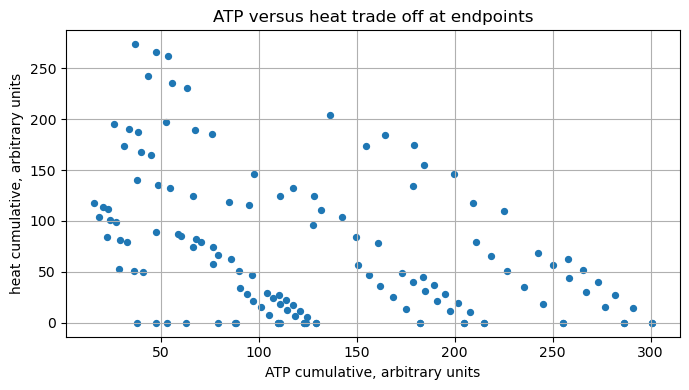

In [17]:

fig, ax = plt.subplots()
ax.scatter(endpoints["atp_cum"], endpoints["heat_cum"], s=18)
ax.set_xlabel("ATP cumulative, arbitrary units")
ax.set_ylabel("heat cumulative, arbitrary units")
ax.set_title("ATP versus heat trade off at endpoints")
plt.tight_layout()
plt.savefig(OUT / "fig_tradeoff_atp_heat.png", dpi=160)
plt.show()


## Effect of UCP activation on ATP output across modes

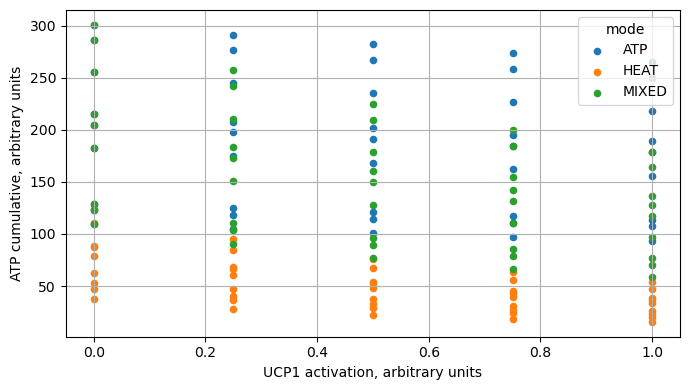

In [20]:

fig, ax = plt.subplots()
for md_mode in sorted(endpoints["mode"].unique()):
    sub = endpoints[endpoints["mode"]==md_mode]
    ax.scatter(sub["ucp1_activation"], sub["atp_cum"], label=md_mode, s=20)
ax.set_xlabel("UCP1 activation, arbitrary units")
ax.set_ylabel("ATP cumulative, arbitrary units")
ax.legend(title="mode")
plt.tight_layout()
plt.savefig(OUT / "fig_ucp_vs_atp.png", dpi=160)
plt.show()


## Heat map of ATP cumulative versus UCP activation and ADP level at fixed pump rate and mode

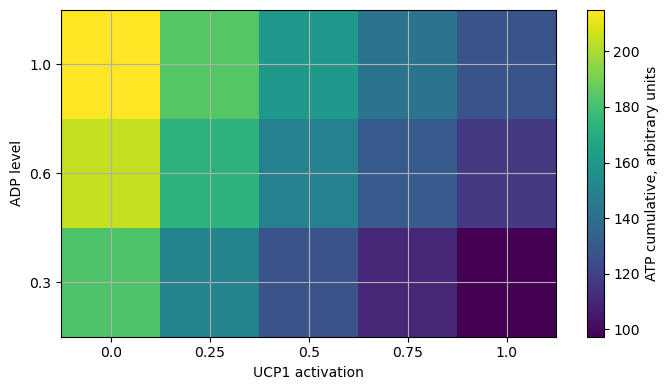

In [23]:

sel = endpoints[(endpoints["pump_rate"]==1.0)&(endpoints["mode"]=="MIXED")]
pivot = sel.pivot(index="adp_level", columns="ucp1_activation", values="atp_cum").sort_index(ascending=True)
fig, ax = plt.subplots()
im = ax.imshow(pivot.values, origin="lower", aspect="auto")
ax.set_xticks(range(len(pivot.columns))); ax.set_xticklabels([str(v) for v in pivot.columns])
ax.set_yticks(range(len(pivot.index))); ax.set_yticklabels([str(v) for v in pivot.index])
ax.set_xlabel("UCP1 activation"); ax.set_ylabel("ADP level")
cb = plt.colorbar(im, ax=ax); cb.set_label("ATP cumulative, arbitrary units")
plt.tight_layout()
plt.savefig(OUT / "fig_heatmap_atp.png", dpi=160)
plt.show()


## Quick parameter fitting from a mock calorimetry like dataset

estimated k_atp, k_u = (0.018333333333333333, 0.019999999999999997) true = 0.018 0.02


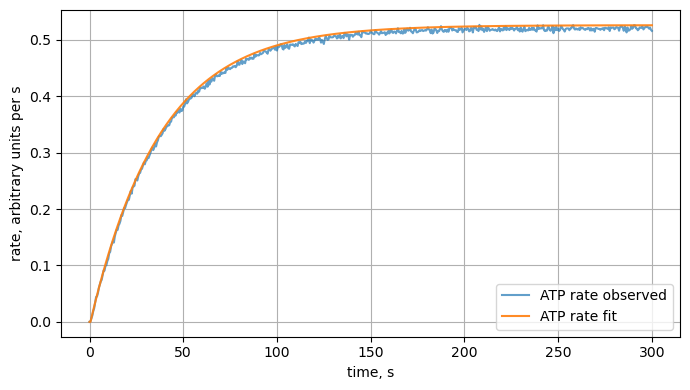

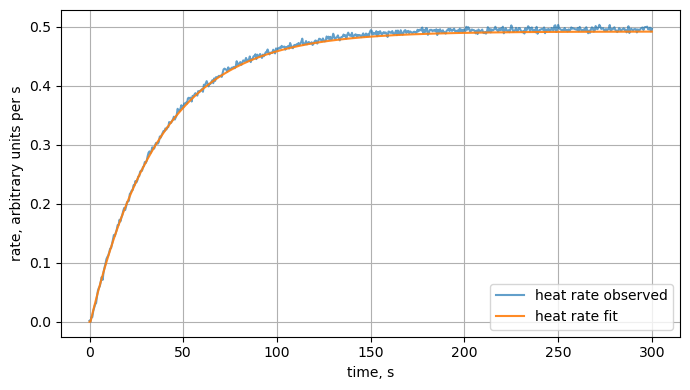

In [26]:

gt = {"pump_rate": 1.1, "k_atp": 0.018, "k_u": 0.020, "ucp1_activation": 0.6, "adp_level": 0.7}
obs = simulate_system(pump_rate=gt["pump_rate"], k_atp=gt["k_atp"], k_u=gt["k_u"],
                      ucp1_activation=gt["ucp1_activation"], adp_level=gt["adp_level"], toggle="MIXED")
rng = np.random.default_rng(7)
obs["atp_rate_obs"] = obs["atp_rate"] + rng.normal(0, 0.003, size=len(obs))
obs["heat_rate_obs"] = obs["heat_rate"] + rng.normal(0, 0.003, size=len(obs))

k_atp_grid = np.linspace(0.010, 0.030, 25)
k_u_grid = np.linspace(0.010, 0.030, 25)

best = None
best_loss = np.inf

for ka in k_atp_grid:
    for ku in k_u_grid:
        sim_try = simulate_system(pump_rate=gt["pump_rate"], k_atp=ka, k_u=ku,
                                  ucp1_activation=gt["ucp1_activation"], adp_level=gt["adp_level"], toggle="MIXED")
        loss = np.mean((sim_try["atp_rate"] - obs["atp_rate_obs"])**2) + np.mean((sim_try["heat_rate"] - obs["heat_rate_obs"])**2)
        if loss < best_loss:
            best_loss = loss
            best = (ka, ku)

print("estimated k_atp, k_u =", best, "true =", gt["k_atp"], gt["k_u"])

fit = simulate_system(pump_rate=gt["pump_rate"], k_atp=best[0], k_u=best[1],
                      ucp1_activation=gt["ucp1_activation"], adp_level=gt["adp_level"], toggle="MIXED")

fig, ax = plt.subplots()
ax.plot(obs["time_s"], obs["atp_rate_obs"], label="ATP rate observed", alpha=0.7)
ax.plot(fit["time_s"], fit["atp_rate"], label="ATP rate fit", alpha=0.9)
ax.set_xlabel("time, s"); ax.set_ylabel("rate, arbitrary units per s"); ax.legend()
plt.tight_layout()
plt.savefig(OUT / "fig_fit_atp_rate.png", dpi=160)
plt.show()

fig, ax = plt.subplots()
ax.plot(obs["time_s"], obs["heat_rate_obs"], label="heat rate observed", alpha=0.7)
ax.plot(fit["time_s"], fit["heat_rate"], label="heat rate fit", alpha=0.9)
ax.set_xlabel("time, s"); ax.set_ylabel("rate, arbitrary units per s"); ax.legend()
plt.tight_layout()
plt.savefig(OUT / "fig_fit_heat_rate.png", dpi=160)
plt.show()


## Rank designs by efficiency and export a summary table

In [29]:

ranked = endpoints.sort_values("efficiency", ascending=False).copy()
ranked["rank"] = np.arange(1, len(ranked)+1)
summary_cols = ["rank","pump_rate","ucp1_activation","adp_level","mode","efficiency","atp_cum","heat_cum"]
rank_path = OUT / "efficiency_rankings.csv"
ranked.to_csv(rank_path, index=False)
print("wrote", rank_path)
ranked[summary_cols].head(12)


wrote results_full/efficiency_rankings.csv


,rank,pump_rate,ucp1_activation,adp_level,mode,efficiency,atp_cum,heat_cum
59498,1,1.4,0.0,1.0,MIXED,1.0,300.793484,0.0
58296,2,1.4,0.0,1.0,ATP,1.0,300.793484,0.0
57695,3,1.4,0.0,0.6,MIXED,1.0,286.606352,0.0
56493,4,1.4,0.0,0.6,ATP,1.0,286.606352,0.0
54690,5,1.4,0.0,0.3,ATP,1.0,255.405601,0.0
55892,6,1.4,0.0,0.3,MIXED,1.0,255.405601,0.0
32453,7,1.0,0.0,1.0,MIXED,1.0,214.852489,0.0
31251,8,1.0,0.0,1.0,ATP,1.0,214.852489,0.0
30650,9,1.0,0.0,0.6,MIXED,1.0,204.718823,0.0
29448,10,1.0,0.0,0.6,ATP,1.0,204.718823,0.0


## Phenotype hierarchy, ATP production efficiency

We now define phenotype like parameter sets, simulate mixed mode outputs, and compute a composite score.

In [33]:

phenotypes = {
    "Skeletal muscle": dict(pump_rate=1.5, k_atp=0.023, k_u=0.011, ucp1_activation=0.05, adp_level=1.0),
    "Heart":            dict(pump_rate=1.4, k_atp=0.022, k_u=0.010, ucp1_activation=0.10, adp_level=1.0),
    "Neuron":           dict(pump_rate=1.2, k_atp=0.021, k_u=0.012, ucp1_activation=0.20, adp_level=0.9),
    "Liver":            dict(pump_rate=1.0, k_atp=0.019, k_u=0.014, ucp1_activation=0.20, adp_level=0.8),
    "Brown adipose":    dict(pump_rate=1.3, k_atp=0.018, k_u=0.025, ucp1_activation=0.80, adp_level=0.7),
    "Proliferative":    dict(pump_rate=0.9, k_atp=0.017, k_u=0.016, ucp1_activation=0.20, adp_level=0.6),
}


In [35]:

records = []
time_series = {}
for name, p in phenotypes.items():
    df = simulate_system(pump_rate=p["pump_rate"], k_atp=p["k_atp"], k_u=p["k_u"],
                         ucp1_activation=p["ucp1_activation"], adp_level=p["adp_level"], toggle="MIXED")
    time_series[name] = df
    end = df.iloc[-1]
    efficiency = end["atp_cum"] / (end["atp_cum"] + end["heat_cum"] + 1e-9)
    records.append(dict(
        phenotype=name,
        pmf=end["pmf"],
        atp_cum=end["atp_cum"],
        heat_cum=end["heat_cum"],
        efficiency=efficiency
    ))
summary = pd.DataFrame.from_records(records).sort_values("efficiency", ascending=False).reset_index(drop=True)
summary_path = OUT / "phenotype_summary.csv"
summary.to_csv(summary_path, index=False)
print("wrote", summary_path)
summary


wrote results_full/phenotype_summary.csv


,phenotype,pmf,atp_cum,heat_cum,efficiency
0,Skeletal muscle,73.936624,328.689251,10.217948,0.969850
1,Heart,70.097284,297.214662,17.562685,0.944206
2,Neuron,59.416488,234.947410,35.801510,0.867769
3,Liver,53.514615,182.938371,37.069091,0.831510
4,Proliferative,54.061521,148.022344,41.794544,0.779817
5,Brown adipose,37.571189,128.341128,203.716076,0.386503


In [37]:

extras = []
for name, p in phenotypes.items():
    df_hi = simulate_system(pump_rate=p["pump_rate"], k_atp=p["k_atp"], k_u=p["k_u"],
                            ucp1_activation=p["ucp1_activation"], adp_level=p["adp_level"], toggle="MIXED")
    df_lo = simulate_system(pump_rate=p["pump_rate"], k_atp=p["k_atp"], k_u=p["k_u"],
                            ucp1_activation=p["ucp1_activation"], adp_level=0.05, toggle="MIXED")
    diss_hi = df_hi["atp_rate"].iloc[-1] + df_hi["heat_rate"].iloc[-1]
    diss_lo = df_lo["atp_rate"].iloc[-1] + df_lo["heat_rate"].iloc[-1]
    rcr_proxy = (diss_hi + 1e-9) / (diss_lo + 1e-9)
    df_boost = simulate_system(pump_rate=1.3*p["pump_rate"], k_atp=p["k_atp"], k_u=p["k_u"],
                               ucp1_activation=p["ucp1_activation"], adp_level=p["adp_level"], toggle="MIXED")
    spare = (df_boost["atp_rate"].iloc[-1] + df_boost["heat_rate"].iloc[-1]) - (df_hi["atp_rate"].iloc[-1] + df_hi["heat_rate"].iloc[-1])
    extras.append(dict(phenotype=name, rcr_proxy=rcr_proxy, spare_capacity=spare, pmf_end=df_hi["pmf"].iloc[-1]))
extras = pd.DataFrame(extras)
full = summary.merge(extras, on="phenotype")

def z(x):
    x = np.asarray(x, dtype=float)
    return (x - x.mean()) / (x.std() + 1e-9)

w_eff, w_rcr, w_spare, w_pmf = 0.5, 0.2, 0.2, 0.1
full["composite_score"] = w_eff*z(full["efficiency"]) + w_rcr*z(full["rcr_proxy"]) + w_spare*z(full["spare_capacity"]) + w_pmf*z(full["pmf_end"])
full_sorted = full.sort_values("composite_score", ascending=False).reset_index(drop=True)
rank_path = OUT / "phenotype_rankings.csv"
full_sorted.to_csv(rank_path, index=False)
print("wrote", rank_path)
full_sorted


wrote results_full/phenotype_rankings.csv


,phenotype,pmf,atp_cum,heat_cum,efficiency,rcr_proxy,spare_capacity,pmf_end,composite_score
0,Skeletal muscle,73.936624,328.689251,10.217948,0.969850,1.655598,0.404623,73.936624,1.093612
1,Heart,70.097284,297.214662,17.562685,0.944206,1.581033,0.376898,70.097284,0.830447
2,Neuron,59.416488,234.947410,35.801510,0.867769,1.381466,0.323515,59.416488,0.171252
3,Liver,53.514615,182.938371,37.069091,0.831510,1.353838,0.266785,53.514615,-0.185727
4,Proliferative,54.061521,148.022344,41.794544,0.779817,1.316567,0.235695,54.061521,-0.453438
5,Brown adipose,37.571189,128.341128,203.716076,0.386503,1.026277,0.367446,37.571189,-1.456147


## Figures for phenotype hierarchy

/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_74730/3565436968.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(full_sorted["phenotype"], rotation=45, ha="right")


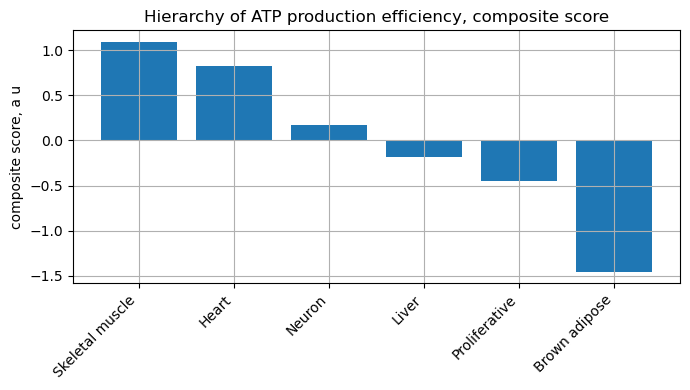

In [40]:

fig, ax = plt.subplots()
ax.bar(full_sorted["phenotype"], full_sorted["composite_score"])
ax.set_xticklabels(full_sorted["phenotype"], rotation=45, ha="right")
ax.set_ylabel("composite score, a u")
ax.set_title("Hierarchy of ATP production efficiency, composite score")
plt.tight_layout()
plt.savefig(OUT / "fig_hierarchy_bar.png", dpi=160)
plt.show()


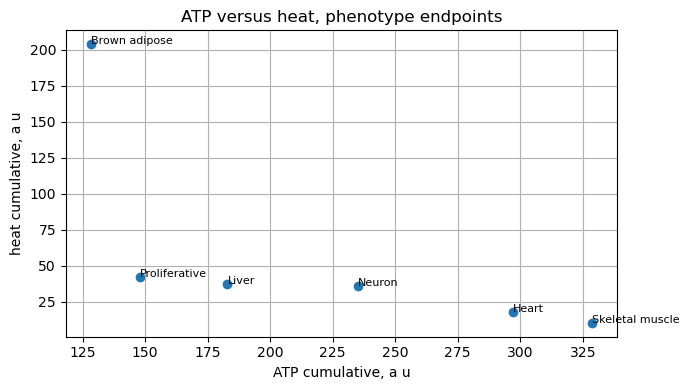

In [42]:

fig, ax = plt.subplots()
ax.scatter(full_sorted["atp_cum"], full_sorted["heat_cum"])
for i, row in full_sorted.iterrows():
    ax.text(row["atp_cum"], row["heat_cum"], row["phenotype"], fontsize=8)
ax.set_xlabel("ATP cumulative, a u")
ax.set_ylabel("heat cumulative, a u")
ax.set_title("ATP versus heat, phenotype endpoints")
plt.tight_layout()
plt.savefig(OUT / "fig_atp_vs_heat_points.png", dpi=160)
plt.show()


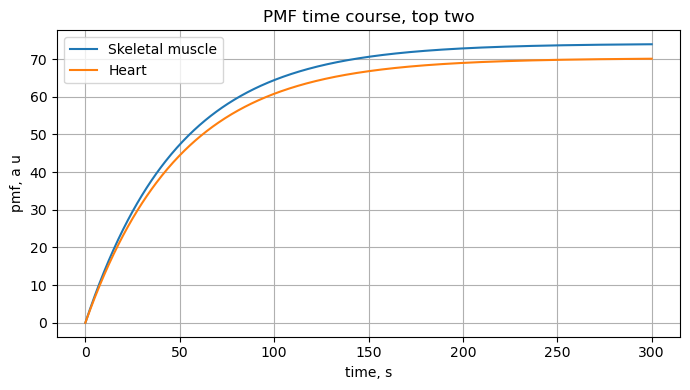

In [44]:

top_two = list(full_sorted["phenotype"].head(2).values)
fig, ax = plt.subplots()
for name in top_two:
    df = time_series[name]
    ax.plot(df["time_s"], df["pmf"], label=name)
ax.set_xlabel("time, s"); ax.set_ylabel("pmf, a u"); ax.legend(); ax.set_title("PMF time course, top two")
plt.tight_layout()
plt.savefig(OUT / "fig_pmf_timecourses_top2.png", dpi=160)
plt.show()
